In [1]:
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.init_plotting()

model = finesse.script.parse("""
###############################################################################
###   length definitions
###############################################################################
variable Larm 3994.47
variable LPR23 16.164  # distance between PR2 and PR3
variable LPR3BS 19.538 # distance between PR3 and BS
variable lmich 5.342   # average length of MICH
variable lschnupp 0.08
variable lPRC (3+0.5)*c0/(2*f1) # T1000298 Eq2.1, N=3

variable f1 9099471
variable f2 5*f1
variable nsilica 1.45
variable Mloss 0

laser L0 P=1
mod mod1 f=f1 midx=0.2
link(L0, mod1, PRM)
m PRM T=0.03 L=0 Rc=11.009 phi=0
s lp1 PRM.p2 PR2.p1 L=lPRC-LPR3BS-LPR23-lmich
bs PR2 T=250u L=Mloss alpha=-0.79 Rc=-4.545
s lp2 PR2.p2 PR3.p1 L=LPR23
bs PR3 T=0 L=Mloss alpha=0.615 Rc=36.027
s lp3 PR3.p2 BS.p1 L=LPR3BS

###############################################################################
###   BS
###############################################################################
bs BS R=1 L=0 alpha=45

###############################################################################
###   Yarm
###############################################################################
# Distance from beam splitter to Y arm input mirror
s ly1 BS.p2 ITMYlens.p1 L=lmich-lschnupp/2-ITMYsub.L*ITMYsub.nr
lens ITMYlens f=34000
s ly2 ITMYlens.p2 ITMYAR.p1
m ITMYAR R=0 L=20u
s ITMYsub ITMYAR.p2 ITMY.p1 L=0.2 nr=nsilica
m ITMY T=0.014 L=Mloss Rc=-1934
s LY ITMY.p2 ETMY.p1 L=Larm
m ETMY T=5u L=Mloss Rc=2245

pd Parm ETMY.p1.i
pd Prc PRM.p2.o
modes(even, maxtem=12)

ad pu9 PRM.p2.i f=+f1
ad pl9 PRM.p2.i f=-f1
mathd prc_cost log10(Parm/280)+log10(abs(pu9))+log10(abs(pl9))
""")

In [2]:
# make a copy so that we can add different cav commands
_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
# nodes that will be defined by the ITM and ETM geometry
print(_model.cavYARM.path.nodes_only)

[<OpticalNode ETMY.p1.o @ 0x79bc9868bf80>, <OpticalNode ITMY.p2.i @ 0x79bc9864e6c0>, <OpticalNode ITMY.p2.o @ 0x79bc9864da90>, <OpticalNode ETMY.p1.i @ 0x79bc98688500>]


In [3]:
_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
# Maximize the arm power with respect to the PRM curvature and ITMY lens
# There are multiple optimisations that could be done here, depends on what
# parameters you want to vary. This model is naturally astigmatic though due
# to the off-axis telescope.
opt_sol = _model.run("maximize(Parm, [ITMYlens.f, PRM.Rcx, PRM.Rcy, PRM.phi, ETMY.phi])")
print("HOMs Parm =       ", _model.run("noxaxis()")['Parm'])
_model.modes("off")
print("Plane-wave Parm = ", _model.run("noxaxis()")['Parm'])

# the plane-wave and HOM powers should be nearly identical, a sign that there
# is no mode-mismatch. If so, we then update the original model to use these
# new values
model.ITMYlens.f = opt_sol.x[0]
model.PRM.Rcx = opt_sol.x[1]
model.PRM.Rcy = opt_sol.x[2]

# Given the model is now in a perfectly matched state we can also take the
# beam parameter at the input of the PRM and set the original model to use that
model.PRM.p1.i.q = _model.PRM.p1.i.q

HOMs Parm =        32239.430040392363
Plane-wave Parm =  32239.430039709478


In [4]:
model.gausses

{<OpticalNode PRM.p1.i @ 0x79bc9871ff20>: <'gPRM_p1_i' @ 0x79bc983dde50 (Gauss)>}

In [5]:
model.ITMYlens.f = np.inf # opt_sol.x[0] # use opt_sol for perfect matching
model.mismatches_table()

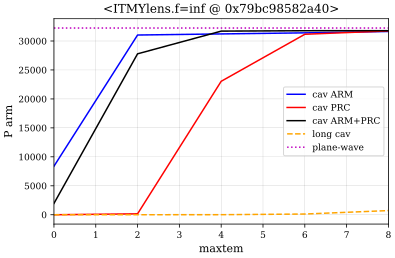

In [6]:
def run(model, orders):
    model.modes("off")
    plane_wave = model.run()
    homs = []
    for n in orders:
        model.modes("even", maxtem=n)
        with model.temporary_parameters():
            homs.append(model.run("""
                series(
                    maximize(Parm, [PRM.phi, ETMY.phi]),
                    noxaxis() # get detector outputs
                )
            """)['noxaxis'])
    return plane_wave, homs

orders = range(0, 10, 2)

_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
plane_wave, homs = run(_model, orders)

_model = model.deepcopy()
_model.parse("cav cavPRC PRM.p2.o via=ITMY.p1.i")
plane_wave2, homs2 = run(_model, orders)

_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o")
_model.parse("cav cavPRC PRM.p2.o via=ITMY.p1.i")
plane_wave3, homs3 = run(_model, orders)

_model = model.deepcopy()
_model.parse("cav cavYARM ETMY.p1.o via=PRM.p2.i")
plane_wave4, homs4 = run(_model, orders)

plt.plot(orders, tuple(_['Parm'] for _ in homs), label='cav ARM')
plt.plot(orders, tuple(_['Parm'] for _ in homs2), label='cav PRC')
plt.plot(orders, tuple(_['Parm'] for _ in homs3), label='cav ARM+PRC')
plt.plot(orders, tuple(_['Parm'] for _ in homs4), label='long cav', ls='--')
plt.hlines(plane_wave['Parm'], 0, 8, ls=':', color='m', label='plane-wave')
plt.legend()
plt.xlabel("maxtem")
plt.ylabel("P arm")
plt.title(repr(model.ITMYlens.f));